# Face Mask Detection

This is a program that is able to detect whether a person is wearing a face mask or not, and whether the face mask is worn properly.

We first get our images that will be used for our model training. Images are taken from Kaggle from the following link: https://www.kaggle.com/andrewmvd/face-mask-detection

In [1]:
import numpy as np 
import pandas as pd

import os
for dirname, _, filenames in os.walk('C:/Users/Rais/Desktop/Soft Computing/Assignment/mask_data'): #Rename the file directory to where ever you store the image
    for filename in filenames:
        print(os.path.join(dirname, filename))


C:/Users/Rais/Desktop/Soft Computing/Assignment/mask_data\annotations\maksssksksss0.xml
C:/Users/Rais/Desktop/Soft Computing/Assignment/mask_data\annotations\maksssksksss1.xml
C:/Users/Rais/Desktop/Soft Computing/Assignment/mask_data\annotations\maksssksksss10.xml
C:/Users/Rais/Desktop/Soft Computing/Assignment/mask_data\annotations\maksssksksss100.xml
C:/Users/Rais/Desktop/Soft Computing/Assignment/mask_data\annotations\maksssksksss101.xml
C:/Users/Rais/Desktop/Soft Computing/Assignment/mask_data\annotations\maksssksksss102.xml
C:/Users/Rais/Desktop/Soft Computing/Assignment/mask_data\annotations\maksssksksss103.xml
C:/Users/Rais/Desktop/Soft Computing/Assignment/mask_data\annotations\maksssksksss104.xml
C:/Users/Rais/Desktop/Soft Computing/Assignment/mask_data\annotations\maksssksksss105.xml
C:/Users/Rais/Desktop/Soft Computing/Assignment/mask_data\annotations\maksssksksss106.xml
C:/Users/Rais/Desktop/Soft Computing/Assignment/mask_data\annotations\maksssksksss107.xml
C:/Users/Rais/D

We then import all of the libraries that will be used to process the data and train the model.

In [19]:
#import the libraries
import numpy as np
import pandas as pd 
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import cv2
import random as rand

# Data Pre-Processing

In [3]:
# Define functions that performs task 1 mentioned above

#This function will get the coordinates of face given in the annotations file
# the coordinates of lower left corner and upper right corner
def generate_box(obj):  
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

#This function will give label assciated with each label and convert them to numbers
def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0

#Using in this main function we parse the annotations file and get the objects out from them
# Also we use the above two functions here 
def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
            
        boxes=np.array(boxes)
        labels=np.array(labels)

        img_id = np.array(image_id)
    # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return (target,num_objs)

In [4]:
imgs = list(sorted(os.listdir("C:/Users/Rais/Desktop/Soft Computing/Assignment/mask_data/images/")))
len(imgs)

853

In [5]:
labels = list(sorted(os.listdir("C:/Users/Rais/Desktop/Soft Computing/Assignment/mask_data/annotations/")))

In [6]:
# Here we use the above functions and save results in lists
targets=[]#store coordinates
numobjs=[]#stores number of faces in each image
#run the loop for number of images we have
for i in range(853):
    file_image = 'maksssksksss'+ str(i) + '.png'
    file_label = 'maksssksksss'+ str(i) + '.xml'
    img_path = os.path.join("C:/Users/Rais/Desktop/Soft Computing/Assignment/mask_data/images/", file_image)
    label_path = os.path.join("C:/Users/Rais/Desktop/Soft Computing/Assignment/mask_data/annotations/", file_label)
    #Generate Label
    target,numobj = generate_target(i, label_path)
    targets.append(target)
    numobjs.append(numobj)
    

In [7]:
#In this step we carry forward the second step mentioned above.
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
face_images=[]
face_labels=[]
for i in range(853):
    img_path = "C:/Users/Rais/Desktop/Soft Computing/Assignment/mask_data/images/maksssksksss{}.png".format(i)
    #read image
    img = cv2.imread(img_path)
    for j in range(numobjs[i]):
#       get coordinates of ith image in list 
        locs=(targets[i]['boxes'][j])
#     Get the face from the image using the coordinates
#the arguments are as ymin , ymax and xmin xmax
        img1=img[locs[1]:locs[3],locs[0]:locs[2]]
        img1 = cv2.resize(img1, (224, 224))
        img1 = img_to_array(img1)
        img1 = preprocess_input(img1)
        face_images.append(img1)
        face_labels.append(targets[i]['labels'][j])

face_images= np.array(face_images, dtype="float32")
face_labels = np.array(face_labels)



Next we check total number of faces detected and how many belong to each class. We see that the images in which mask is worn incorrectly are really less. We will increase their weight when training the model.

In [8]:
len(face_labels)

4072

In [9]:
unique, counts = np.unique(face_labels, return_counts=True)
dict(zip(unique, counts))

{0: 717, 1: 3232, 2: 123}

In [10]:
#Encode the labels in one hot encode form
lb = LabelEncoder()
labels = lb.fit_transform(face_labels)
labels = to_categorical(labels)
labels

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [11]:
#Perform data augmentation.
aug = ImageDataGenerator(
    zoom_range=0.1,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
    )

# Model Training

In [12]:
#define the model
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_shape=(224, 224, 3))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.25)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [13]:
#define the hyperparamets for traing te neural network
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [14]:
#divide data into training and testing sets
(trainX, testX, trainY, testY) = train_test_split(face_images, labels,
	test_size=0.2, stratify=labels, random_state=42)

In [15]:
#Free some space.I did this tep as the notebook was running out of space while training
del targets,face_images,face_labels

In [16]:
#Complie the model and train it
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS,
class_weight = {0:5 , 1:1, 2:10}) #Here we sets weights to each class. 
#Class having high weight will be considered more importat while training

Epoch 1/20
101/101 [==============================] - 83s 820ms/step - loss: 1.7079 - accuracy: 0.6614 - val_loss: 0.7990 - val_accuracy: 0.6123
Epoch 2/20
101/101 [==============================] - 77s 764ms/step - loss: 1.2608 - accuracy: 0.7966 - val_loss: 0.5765 - val_accuracy: 0.7448
Epoch 3/20
101/101 [==============================] - 79s 779ms/step - loss: 1.1735 - accuracy: 0.7997 - val_loss: 0.4108 - val_accuracy: 0.8344
Epoch 4/20
101/101 [==============================] - 79s 786ms/step - loss: 1.0098 - accuracy: 0.8236 - val_loss: 0.4980 - val_accuracy: 0.7890
Epoch 5/20
101/101 [==============================] - 78s 770ms/step - loss: 0.9746 - accuracy: 0.8375 - val_loss: 0.3824 - val_accuracy: 0.8380
Epoch 6/20
101/101 [==============================] - 77s 766ms/step - loss: 0.9380 - accuracy: 0.8462 - val_loss: 0.4372 - val_accuracy: 0.8172
Epoch 7/20
101/101 [==============================] - 78s 776ms/step - loss: 0.8852 - accuracy: 0.8595 - val_loss: 0.4420 - val_ac

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.62      0.94      0.74       143
           1       0.97      0.84      0.90       647
           2       0.33      0.52      0.41        25

    accuracy                           0.85       815
   macro avg       0.64      0.77      0.68       815
weighted avg       0.89      0.85      0.86       815

[[134   7   2]
 [ 79 544  24]
 [  4   8  13]]


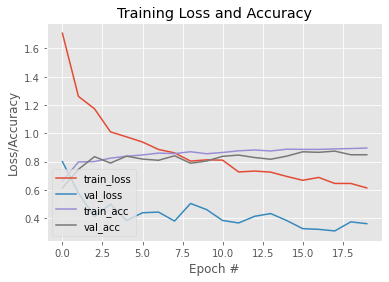

In [22]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=32)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs))

# print the confusion matrix
print(confusion_matrix(testY.argmax(axis=1), predIdxs))

# # serialize the model to disk
# print("[INFO] saving mask detector model...")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [15]:
#save the model and name it as you wish.
model.save('face_mask_detection')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: face_mask_detection\assets


# Model Implementation

In [1]:
#load the saved model
import keras
model = keras.models.load_model('face_mask_detection')

In [28]:
cascPath = os.path.dirname(
    cv2.__file__) + "/data/haarcascade_frontalface_alt2.xml"
faceCascade = cv2.CascadeClassifier(cascPath)

image_name = 'maksssksksss160.png'#Change to image that you want to classify

image = cv2.imread(image_name)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
faces = faceCascade.detectMultiScale(gray,
                                     scaleFactor=1.1,
                                     minNeighbors=5,
                                     minSize=(60, 60),
                                     flags=cv2.CASCADE_SCALE_IMAGE)

print("Found {0} faces!".format(len(faces)))

faces_list=[]
preds=[]
for (x, y, w, h) in faces:
    face_frame = image[y:y+h,x:x+w]
    face_frame = cv2.cvtColor(face_frame, cv2.COLOR_BGR2RGB)
    face_frame = cv2.resize(face_frame, (224, 224))
    face_frame = img_to_array(face_frame)
    face_frame = np.expand_dims(face_frame, axis=0)
    face_frame =  preprocess_input(face_frame)
    preds = model(face_frame)
    for pred in preds:
        (mask, withoutMask,notproper) = pred
    
    # determine the class label and color we'll use to draw
    # the bounding box and text
    if (mask > withoutMask and mask>notproper):
        label = "Without Mask"
    elif ( withoutMask > notproper and withoutMask > mask):
        label = "Mask"
    else:
        label = "Wear Mask Properly"

    if label == "Mask":
        color = (0, 255, 0)
    elif label=="Without Mask":
        color = (0, 0, 255)
    else:
        color = (255, 140, 0)

    # include the probability in the label
    label = "{}: {:.2f}%".format(label,
                                max(mask, withoutMask, notproper) * 100)

    # display the label and bounding box rectangle on the output
    # frame
    cv2.putText(image, label, (x, y- 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
    cv2.rectangle(image, (x, y), (x + w, y + h),color, 2)

cv2.imwrite('Predicted'+image_name, image)
cv2.imshow("Faces found", image)
cv2.waitKey(0)

Found 1 faces!


-1

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

In [27]:
cascPath = os.path.dirname(
    cv2.__file__) + "/data/haarcascade_frontalface_alt2.xml"
faceCascade = cv2.CascadeClassifier(cascPath)
 
video_capture = cv2.VideoCapture(0)
while True:
    # Capture frame-by-frame
    ret, frame = video_capture.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray,
                                         scaleFactor=1.1,
                                         minNeighbors=5,
                                         minSize=(60, 60),
                                         flags=cv2.CASCADE_SCALE_IMAGE)
    faces_list=[]
    preds=[]
    for (x, y, w, h) in faces:
        face_frame = frame[y:y+h,x:x+w]
        face_frame = cv2.cvtColor(face_frame, cv2.COLOR_BGR2RGB)
        face_frame = cv2.resize(face_frame, (224, 224))
        face_frame = img_to_array(face_frame)
        face_frame = np.expand_dims(face_frame, axis=0)
        face_frame =  preprocess_input(face_frame)
        faces_list.append(face_frame)
        if len(faces_list)>0:
            preds = model.predict(faces_list)
        for pred in preds:
            (mask, withoutMask,notproper) = pred

        # determine the class label and color we'll use to draw
        # the bounding box and text
        if (mask > withoutMask and mask>notproper):
            label = "Without Mask"
        elif ( withoutMask > notproper and withoutMask > mask):
            label = "Mask"
        else:
            label = "Wear Mask Properly"

        if label == "Mask":
            color = (0, 255, 0)
        elif label=="Without Mask":
            color = (0, 0, 255)
        else:
            color = (255, 140, 0)

        # include the probability in the label
        label = "{}: {:.2f}%".format(label,
                                     max(mask, withoutMask, notproper) * 100)

        # display the label and bounding box rectangle on the output
        # frame
        cv2.putText(frame, label, (x, y- 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (x, y), (x + w, y + h),color, 2)
        # Display the resulting frame
    cv2.imshow('Video', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
video_capture.release()
cv2.destroyAllWindows()
